# GroupBy

**Prerequisites**

- {doc}`Functions <../python_fundamentals/functions>`
- pandas introduction {doc}`1 <intro>` and {doc}`2 <basics>`
- {doc}`Reshape <reshape>`

**Outcomes**

- Understand the split-apply-combine strategy for aggregate
  computations on groups of data
- Be able use basic aggregation methods on `df.groupby` to compute
  within group statistics
- Understand how to group by multiple keys at once

**Data**

- Details for all delayed US domestic flights in December 2016,
  obtained from the [Bureau of Transportation
  Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)
  
```{literalinclude} ../_static/colab_light.raw
```

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Split-Apply-Combine

One powerful paradigm for analyzing data is the "Split-Apply-Combine"
strategy.

This strategy has three steps:

1. `Split`: split the data into groups based on values in one or more columns.
1. `Apply`: apply a function or routine to each group separately.
1. `Combine`: combine the output of the apply step into a DataFrame,
   using the group identifiers as the index.

We will cover the main components in this lecture, but we encourage you
to also study the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html)
to learn more about what is possible.

To describe the concepts, we will need some data.

We will begin with a simple made-up dataset to discuss the concepts and
then work through extended example and exercises with real data.

In [2]:
C = np.arange(1, 7, dtype=float)
C[[3, 5]] = np.nan
df = pd.DataFrame({
    "A" : [1, 1, 1, 2, 2, 2],
    "B" : [1, 1, 2, 2, 1, 1],
    "C": C,
})
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


### Simple Example

To perform the *Split* step, we call the `groupby` method on our
DataFrame.

The first argument to `groupby` is a description of how we want to
construct groups.

In the most basic version, we will pass a string identifying the column
name.

In [3]:
gbA = df.groupby("A")

The `type` of variable we get back is a `DataFrameGroupBy`, which we
will sometimes refer to as GroupBy for short.

In [4]:
type(gbA)

pandas.core.groupby.generic.DataFrameGroupBy

Looking at the "groups" inside of the GroupBy object can help us
understand what the GroupBy represents.

We can do this with the `gb.get_group(group_name)` method.

In [5]:
gbA.get_group(1)

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0


In [6]:
gbA.get_group(2)

,A,B,C
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


We can *apply* some of our favorite aggregation functions directly on the
`GroupBy` object.

````{admonition} Exercise
:name: pd-grp-dir1
See exercise 1 in the {ref}`exercise list <pd-grp-ex>`.
````
````{admonition} Exercise
:name: pd-grp-dir2
See exercise 2 in the {ref}`exercise list <pd-grp-ex>`.
````


If we pass a list of strings to `groupby`, it will group based on
unique combinations of values from all columns in the list.

Let's see an example.

In [7]:
gbAB = df.groupby(["A", "B"])
type(gbAB)

pandas.core.groupby.generic.DataFrameGroupBy

In [8]:
gbAB.get_group((1, 1))

,A,B,C
0,1,1,1.0
1,1,1,2.0


Notice that we still have a GroupBy object, so we can apply our favorite
aggregations.

In [9]:
gbAB.count()

C
A B   
1 1  2
  2  1
2 1  1
  2  0

Notice that the output is a DataFrame with two levels on the index
and a single column `C`. (Quiz: how do we know it is a DataFrame with
one column and not a Series?)

This highlights a principle of how pandas handles the *Combine* part of
the strategy:

> The index of the combined DataFrame will be the group identifiers,
> with one index level per group key.

### Custom Aggregate Functions

So far, we have been applying built-in aggregations to our GroupBy object.

We can also apply custom aggregations to each group of a GroupBy in two
steps:

1. Write our custom aggregation as a Python function.
1. Passing our function as an argument to the `.agg` method of a GroupBy.

Let's see an example.

In [10]:
def num_missing(df):
    "Return the number of missing items in each column of df"
    return df.isnull().sum()

We can call this function on our original DataFrame to get the number of
missing items in each column.

In [11]:
num_missing(df)

A    0
B    0
C    2
dtype: int64

We can also apply it to a GroupBy object to get the number of missing
items in each column *for each group*.

In [12]:
gbA.agg(num_missing)

,B,C
A,,
1,0,0
2,0,2


The key to keep in mind is that the function we pass to `agg` should
take in a DataFrame (or Series) and return a Series (or single value)
with one item per column in the original DataFrame.

When the function is called, the data for each group will be passed to
our function as a DataFrame (or Series).

### Transforms: The `apply` Method

As we saw in the {doc}`basics lecture <basics>`, we can apply transforms to DataFrames.

We can do the same with GroupBy objects using the `.apply` method.

Let's see an example.

In [13]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [14]:
def smallest_by_b(df):
    return df.nsmallest(2, "B")

In [15]:
gbA.apply(smallest_by_b)

A  B    C
A             
1 0  1  1  1.0
  1  1  1  2.0
2 4  2  1  5.0
  5  2  1  NaN

Notice that the return value from applying our series transform to `gbA`
was the group key on the outer level (the `A` column) and the original
index from `df` on the inner level.

The original index came along because that was the index of the
DataFrame returned by `smallest_by_b`.

Had our function returned something other than the index from `df`,
that would appear in the result of the call to `.apply`.

````{admonition} Exercise
:name: pd-grp-dir3
See exercise 3 in the {ref}`exercise list <pd-grp-ex>`.
````

### `pd.Grouper`

Sometimes, in order to construct the groups you want, you need to give
pandas more information than just a column name.

Some examples are:

- Grouping by a column and a level of the index.
- Grouping time series data at a particular frequency.

pandas lets you do this through the `pd.Grouper` type.

To see it in action, let's make a copy of `df` with `A` moved to the
index and a `Date` column added.

In [16]:
df2 = df.copy()
df2["Date"] = pd.date_range(
    start=pd.datetime.today().strftime("%m/%d/%Y"),
    freq="BQ",
    periods=df.shape[0]
)
df2 = df2.set_index("A")
df2

/tmp/ipykernel_4046/2961039157.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start=pd.datetime.today().strftime("%m/%d/%Y"),


,B,C,Date
A,,,
1,1,1.0,2021-09-30
1,1,2.0,2021-12-31
1,2,3.0,2022-03-31
2,2,NaN,2022-06-30
2,1,5.0,2022-09-30
2,1,NaN,2022-12-30


We can group by year.

In [17]:
df2.groupby(pd.Grouper(key="Date", freq="A")).count()

,B,C
Date,,
2021-12-31,2,2
2022-12-31,4,2


We can group by the `A` level of the index.

In [18]:
df2.groupby(pd.Grouper(level="A")).count()

,B,C,Date
A,,,
1,3,3,3
2,3,1,3


We can combine these to group by both.

In [19]:
df2.groupby([pd.Grouper(key="Date", freq="A"), pd.Grouper(level="A")]).count()

B  C
Date       A      
2021-12-31 1  2  2
2022-12-31 1  1  1
           2  3  1

And we can combine `pd.Grouper` with a string, where the string
denotes a column name

In [20]:
df2.groupby([pd.Grouper(key="Date", freq="A"), "B"]).count()

C
Date       B   
2021-12-31 1  2
2022-12-31 1  1
           2  1

## Case Study: Airline Delays

Let's apply our new split-apply-combine skills to the airline dataset we
saw in the {doc}`merge <merge>` lecture.

In [21]:
url = "https://datascience.quantecon.org/assets/data/airline_performance_dec16.csv.zip"
air_dec = pd.read_csv(url, parse_dates = ['Date'])

First, we compute the average delay in arrival time for all carriers
each week.

In [22]:
weekly_delays = (
    air_dec
    .groupby([pd.Grouper(key="Date", freq="W"), "Carrier"])
    ["ArrDelay"]               # extract one column
    .mean()                    # take average
    .unstack(level="Carrier")  # Flip carrier up as column names
)
weekly_delays

Carrier,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
Date,,,,,,,,,,,,
2016-12-04,-1.714887,2.724273,-2.894269,-5.088351,8.655332,-2.894212,-0.558282,5.468909,2.749573,5.564496,-2.121821,-1.663695
2016-12-11,1.148833,12.052031,5.795062,2.507745,13.220673,4.578861,2.054302,8.713755,15.429660,4.094176,12.080938,1.865933
2016-12-18,16.357561,7.643767,34.608356,18.000000,23.876622,45.014888,9.388889,22.857899,30.901639,22.398130,33.651128,18.373400
2016-12-25,6.364513,2.719699,5.586836,-0.916113,6.857143,54.084959,5.075747,10.443369,15.004780,5.332474,17.286917,10.197685
2017-01-01,2.321836,1.226662,10.661577,2.048116,6.800898,8.280298,6.970016,8.361123,8.971083,0.061786,1.349580,5.213019


Let's also plot this data.

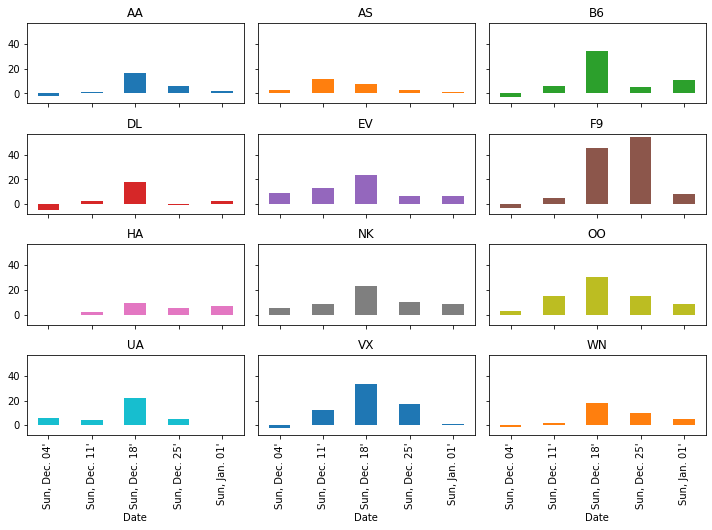

In [23]:
# plot
axs = weekly_delays.plot.bar(
    figsize=(10, 8), subplots=True, legend=False, sharex=True,
    sharey=True, layout=(4, 3), grid=False
)

# tweak spacing between subplots and xaxis labels
axs[0,0].get_figure().tight_layout()
for ax in axs[-1, :]:
    ax.set_xticklabels(weekly_delays.index.strftime("%a, %b. %d'"))

It looks like more delays occurred during the week ending Sunday
December 18th than any other week (except for Frontier, who did *worse*
on Christmas week).

Let's see why.

The `air_dec` DataFrame has information on the minutes of delay
attributed to 5 different categories:

In [24]:
delay_cols = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

Let's take a quick look at each of those delay categories for the week ending December 18, 2016.

In [25]:
pre_christmas = air_dec.loc[
    (air_dec["Date"] >= "2016-12-12") & (air_dec["Date"] <= "2016-12-18")
]

# custom agg function
def positive(df):
    return (df > 0).sum()

delay_totals = pre_christmas.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])
delay_totals

CarrierDelay                     WeatherDelay                     \
                 sum       mean positive          sum      mean positive   
Carrier                                                                    
AA          105732.0   6.258553     2922      21820.0  1.291583      456   
AS            8762.0   2.691032      250       3219.0  0.988636       61   
B6           49421.0   9.031615     1575       9894.0  1.808114      112   
DL          151188.0   8.864212     2878      39145.0  2.295087      783   
EV           87408.0   9.939504     1375       3824.0  0.434842       76   
F9           19568.0  10.430704      361       6198.0  3.303838       57   
HA            7199.0   5.034266      218       3650.0  2.552448      145   
NK           14735.0   5.294646      452       2240.0  0.804887       56   
OO          120307.0  10.439691     1378      26349.0  2.286446      308   
UA           66693.0   6.312636     1851      31602.0  2.991197      521   
VX            8048.0   5.608362      246       3807.0  2.652962      126   
WN          123882.0   4.873790     5393      23516.0  0.925171      328   

        NASDelay                     SecurityDelay                     \
             sum       mean positive           sum      mean positive   
Carrier                                                                 
AA       77279.0   4.574346     3159         721.0  0.042678       35   
AS       16344.0   5.019656      614         163.0  0.050061       10   
B6       38741.0   7.079861     1326         672.0  0.122807       30   
DL       75110.0   4.403729     2605         107.0  0.006273        2   
EV       49703.0   5.651922     1580           0.0  0.000000        0   
F9       22459.0  11.971748      493           0.0  0.000000        0   
HA          86.0   0.060140        4          35.0  0.024476        3   
NK       30361.0  10.909450      840          50.0  0.017966        5   
OO       54141.0   4.698108     2289         171.0  0.014839       12   
UA       74992.0   7.098154     2065           0.0  0.000000        0   
VX       12619.0   8.793728      224          73.0  0.050871        4   
WN       78645.0   3.094067     4247         252.0  0.009914       18   

        LateAircraftDelay                      
                      sum       mean positive  
Carrier                                        
AA               141249.0   8.360897     2574  
AS                13599.0   4.176597      271  
B6               100811.0  18.423063     1433  
DL               122896.0   7.205441     2289  
EV                89773.0  10.208438     1568  
F9                32236.0  17.183369      316  
HA                 4024.0   2.813986      189  
NK                22247.0   7.993891      372  
OO               166102.0  14.413572     2459  
UA               118728.0  11.237861     1696  
VX                25242.0  17.590244      331  
WN               285073.0  11.215399     6472

**Want**: plot total, average, and number of each type of delay by
carrier

To do this, we need to have a DataFrame with:

- Delay type in index (so it is on horizontal-axis)
- Aggregation method on *outer* most level of columns (so we can do
  `data["mean"]` to get averages)
- Carrier name on inner level of columns

Many sequences of the reshaping commands can accomplish this.

We show one example below.

In [26]:
reshaped_delays = (
    delay_totals
    .stack()             # move aggregation method into index (with Carrier)
    .T                   # put delay type in index and Carrier+agg in column
    .swaplevel(axis=1)   # make agg method outer level of column label
    .sort_index(axis=1)  # sort column labels so it prints nicely
)
reshaped_delays

mean                                            \
Carrier                  AA        AS         B6        DL         EV   
CarrierDelay       6.258553  2.691032   9.031615  8.864212   9.939504   
WeatherDelay       1.291583  0.988636   1.808114  2.295087   0.434842   
NASDelay           4.574346  5.019656   7.079861  4.403729   5.651922   
SecurityDelay      0.042678  0.050061   0.122807  0.006273   0.000000   
LateAircraftDelay  8.360897  4.176597  18.423063  7.205441  10.208438   

                                                                         ...  \
Carrier                   F9        HA         NK         OO         UA  ...   
CarrierDelay       10.430704  5.034266   5.294646  10.439691   6.312636  ...   
WeatherDelay        3.303838  2.552448   0.804887   2.286446   2.991197  ...   
NASDelay           11.971748  0.060140  10.909450   4.698108   7.098154  ...   
SecurityDelay       0.000000  0.024476   0.017966   0.014839   0.000000  ...   
LateAircraftDelay  17.183369  2.813986   7.993891  14.413572  11.237861  ...   

                        sum                                               \
Carrier                  B6        DL       EV       F9      HA       NK   
CarrierDelay        49421.0  151188.0  87408.0  19568.0  7199.0  14735.0   
WeatherDelay         9894.0   39145.0   3824.0   6198.0  3650.0   2240.0   
NASDelay            38741.0   75110.0  49703.0  22459.0    86.0  30361.0   
SecurityDelay         672.0     107.0      0.0      0.0    35.0     50.0   
LateAircraftDelay  100811.0  122896.0  89773.0  32236.0  4024.0  22247.0   

                                                          
Carrier                  OO        UA       VX        WN  
CarrierDelay       120307.0   66693.0   8048.0  123882.0  
WeatherDelay        26349.0   31602.0   3807.0   23516.0  
NASDelay            54141.0   74992.0  12619.0   78645.0  
SecurityDelay         171.0       0.0     73.0     252.0  
LateAircraftDelay  166102.0  118728.0  25242.0  285073.0  

[5 rows x 36 columns]

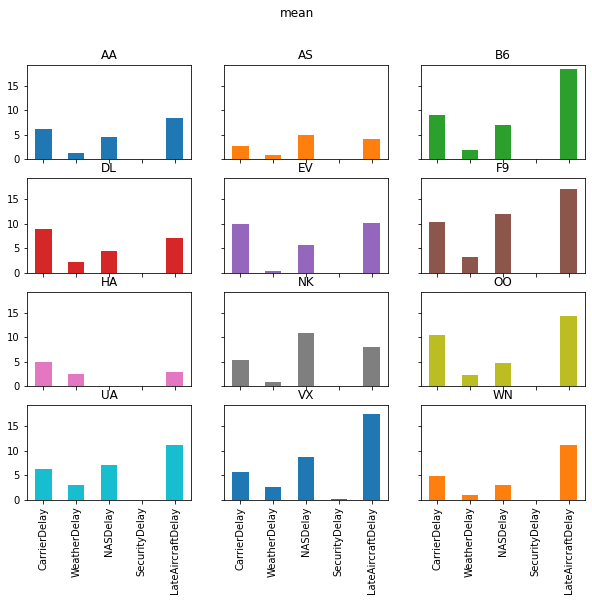

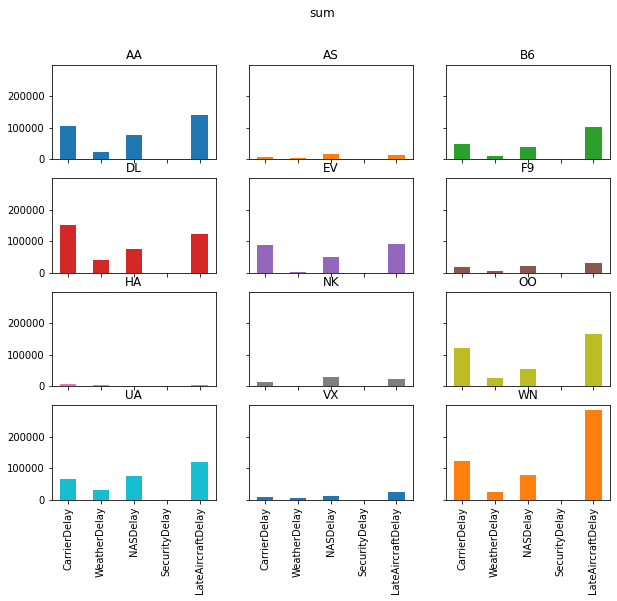

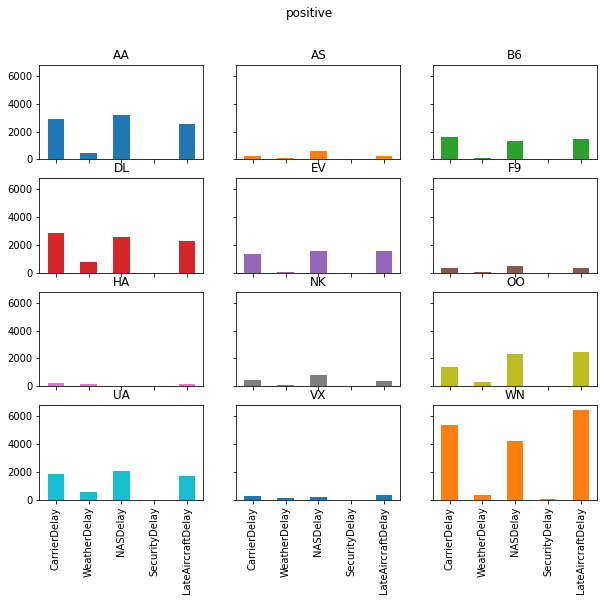

In [27]:
for agg in ["mean", "sum", "positive"]:
    axs = reshaped_delays[agg].plot(
        kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
        sharex=True, sharey=True
    )
    fig = axs[0, 0].get_figure()
    fig.suptitle(agg)
#     fig.tight_layout();

````{admonition} Exercise
:name: pd-grp-dir4
See exercise 4 in the {ref}`exercise list <pd-grp-ex>`.
````

Let's summarize what we did:

- Computed average flight delay for each airline for each week.
- Noticed that one week had more delays for all airlines.
- Studied the flights in that week to determine the *cause* of the
  delays in that week.

Suppose now that we want to repeat that analysis, but at a daily
frequency instead of weekly.

We could copy/paste the code from above and change the `W` to a `D`,
but there's a better way...

Let's convert the steps above into two functions:

1. Produce the set of bar charts for average delays at each frequency.
1. Produce the second set of charts for the total, average, and number
   of occurrences of each type of delay.

In [28]:
def mean_delay_plot(df, freq, figsize=(10, 8)):
    """
    Make a bar chart of average flight delays for each carrier at
    a given frequency.
    """
    mean_delays = (
        df
        .groupby([pd.Grouper(key="Date", freq=freq), "Carrier"])
        ["ArrDelay"]               # extract one column
        .mean()                    # take average
        .unstack(level="Carrier")  # Flip carrier up as column names
    )

    # plot
    axs = mean_delays.plot.bar(
        figsize=figsize, subplots=True, legend=False, sharex=True,
        sharey=True, layout=(4, 3), grid=False
    )

    # tweak spacing between subplots and x-axis labels
    axs[0, 0].get_figure().tight_layout()
    for ax in axs[-1, :]:
        ax.set_xticklabels(mean_delays.index.strftime("%a, %b. %d'"))

    # return the axes in case we want to further tweak the plot outside the function
    return axs


def delay_type_plot(df, start, end):
    """
    Make bar charts for total minutes, average minutes, and number of
    occurrences for each delay type, for all flights that were scheduled
    between `start` date and `end` date
    """
    sub_df = df.loc[
        (df["Date"] >= start) & (df["Date"] <= end)
    ]

    def positive(df):
        return (df > 0).sum()

    aggs = sub_df.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])

    reshaped = aggs.stack().T.swaplevel(axis=1).sort_index(axis=1)

    for agg in ["mean", "sum", "positive"]:
        axs = reshaped[agg].plot(
            kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
            sharex=True, sharey=True
        )
        fig = axs[0, 0].get_figure()
        fig.suptitle(agg)
#         fig.tight_layout();

````{admonition} Exercise
:name: pd-grp-dir5
See exercise 5 in the {ref}`exercise list <pd-grp-ex>`.
````

Now let's look at that plot at a daily frequency. (Note that we need the
figure to be a bit wider in order to see the dates.)

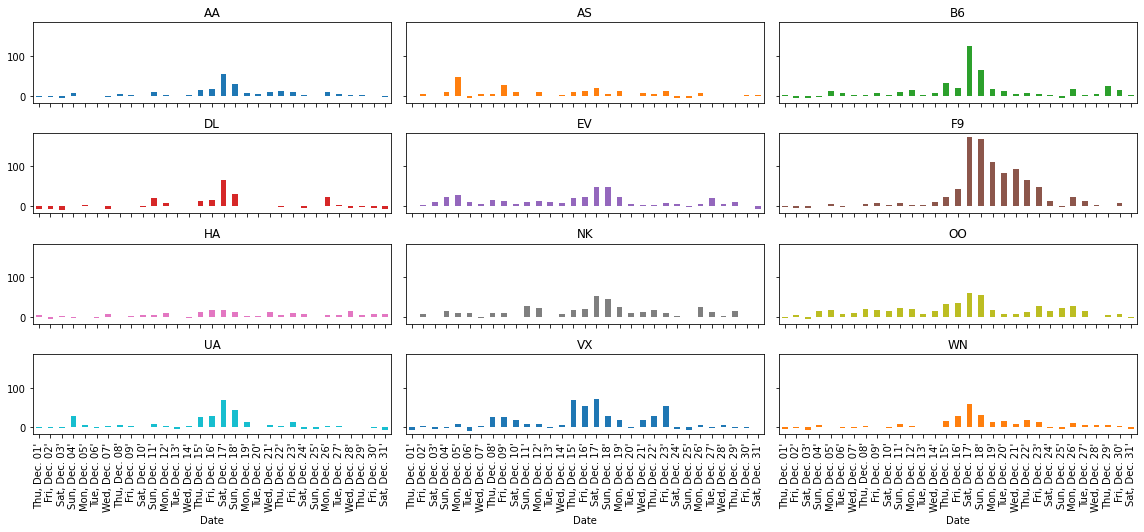

In [29]:
mean_delay_plot(air_dec, "D", figsize=(16, 8));

As we expected given our analysis above, the longest average delays
seemed to happen in the third week.

In particular, it looks like December 17th and 18th had — on average —
higher delays than other days in December.

Let's use the `delay_type_plot` function to determine the cause of the
delays on those two days.

Because our analysis is captured in a single function, we can look at
the days together and separately without much effort.

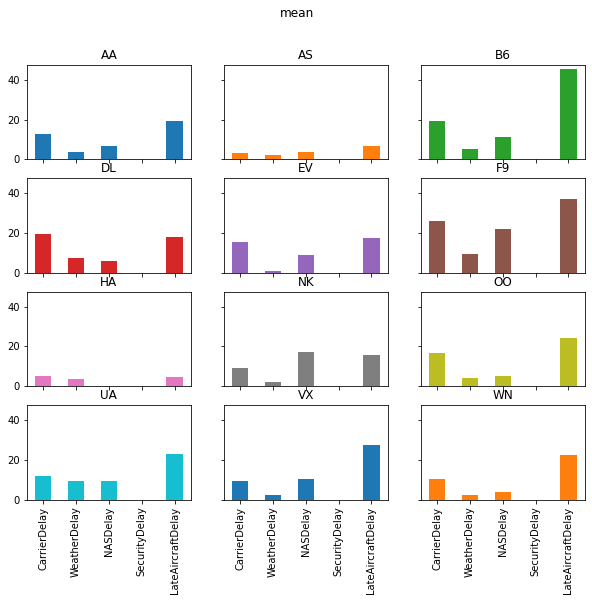

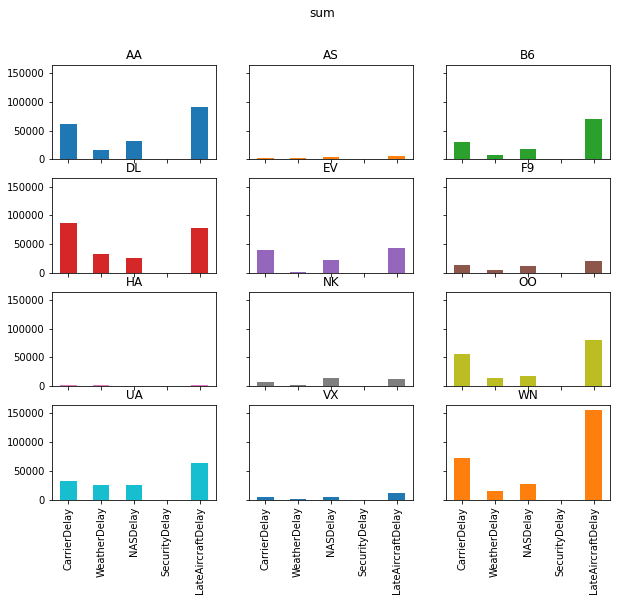

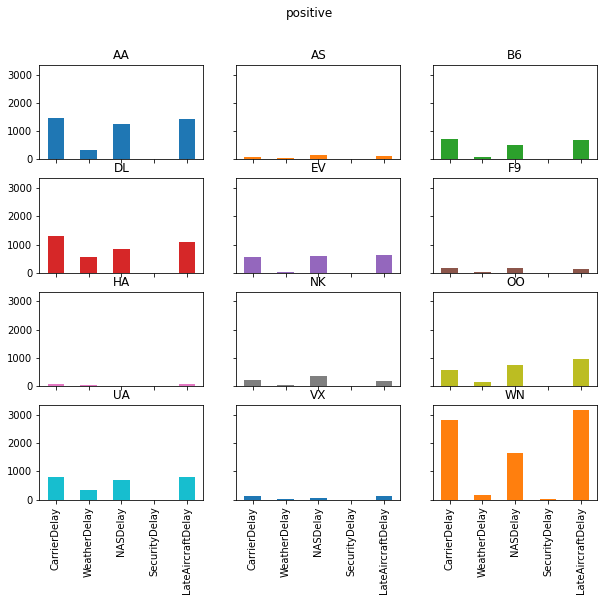

In [30]:
# both days
delay_type_plot(air_dec, "12-17-16", "12-18-16")

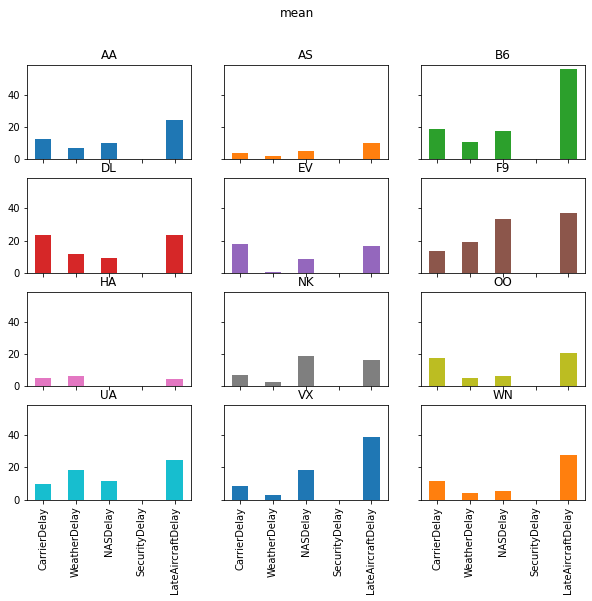

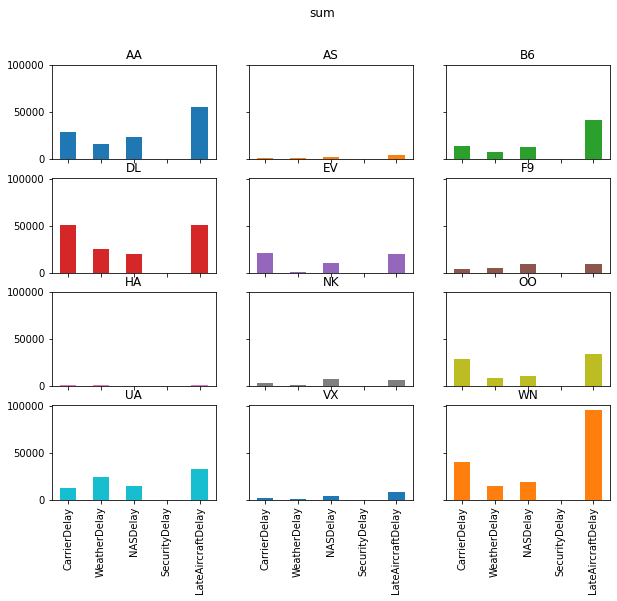

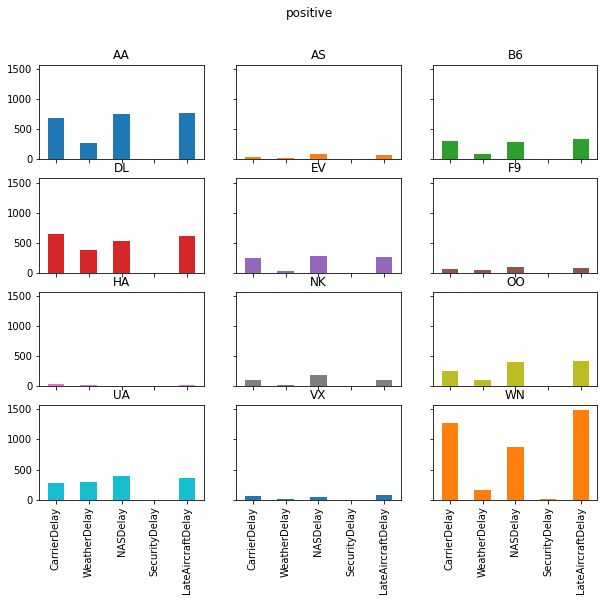

In [31]:
# only the 17th
delay_type_plot(air_dec, "12-17-16", "12-17-16")

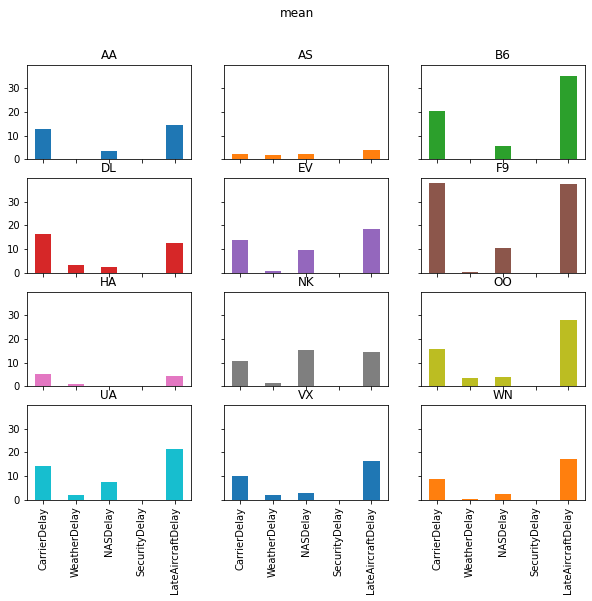

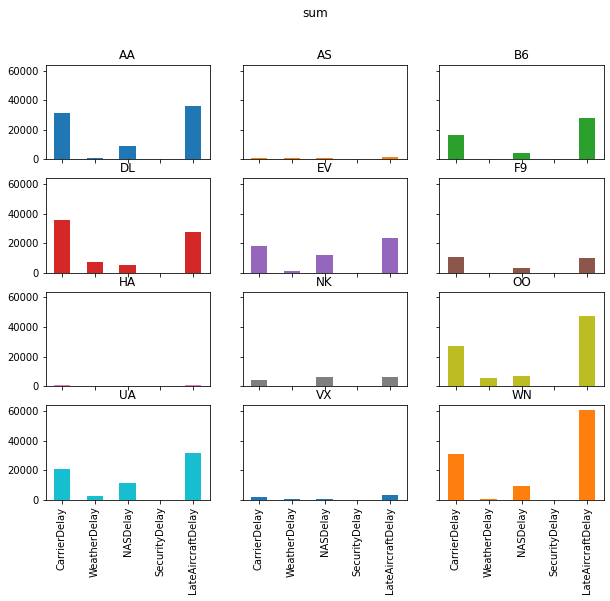

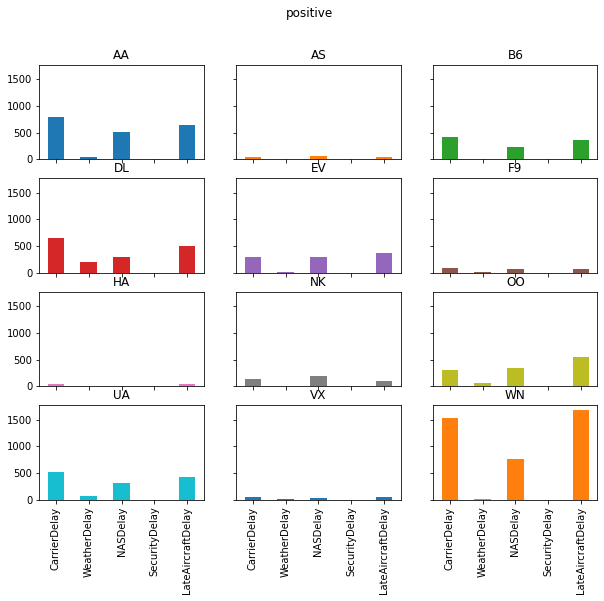

In [32]:
# only the 18th
delay_type_plot(air_dec, "12-18-16", "12-18-16")

The purpose of this exercise was to drive home the ability to *automate*
tasks.

We were able to write a pair of `functions` that allows us to easily
repeat the exact same analysis on different subsets of the data, or
different datasets entirely (e.g. we could do the same analysis on
November 2016 data, with two lines of code).

These principles can be applied in many settings.

Keep that in mind as we work through the rest of the materials.

## Exercise: Cohort Analysis using Shopify Data

The `qeds` library includes routines to simulate data sets in the
format of common sources

One of these sources is [Shopify](https://www.shopify.com/) — an
e-commerce platform used by many retail companies for online sales

The code below will simulate a fairly large data set that has the
properties of a order-detail report from Shopify

We'll first look at the data, and then describe the exercise

In [33]:
# Set the "randomness" seeds
random.seed(42)
np.random.seed(42)

url = "https://datascience.quantecon.org/assets/data/shopify_orders.csv.zip"
orders = pd.read_csv(url)
orders.info()

orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715449 entries, 0 to 715448
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         715449 non-null  int64  
 1   Day                715449 non-null  object 
 2   customer_type      715449 non-null  object 
 3   Customer ID        715449 non-null  int64  
 4   orders             715449 non-null  int64  
 5   total_sales        715449 non-null  float64
 6   Returns            715449 non-null  float64
 7   Ordered quantity   715449 non-null  int64  
 8   Gross sales        715449 non-null  float64
 9   Net sales          715449 non-null  float64
 10  Shipping           715449 non-null  float64
 11  Tax                715449 non-null  float64
 12  Net quantity       715449 non-null  int64  
 13  Returned quantity  715449 non-null  int64  
 14  Discounts          715449 non-null  float64
dtypes: float64(7), int64(6), object(2)
memory usage: 81

,Unnamed: 0,Day,customer_type,Customer ID,orders,total_sales,Returns,Ordered quantity,Gross sales,Net sales,Shipping,Tax,Net quantity,Returned quantity,Discounts
0,0,2019-06-17,Returning,6535260,1,41.03,-0.0,1,41.03,41.03,0.00,0.0,1,0,-0.0
1,1,2015-01-31,First-time,4283889,1,37.96,-0.0,2,37.96,37.96,0.00,0.0,2,0,-0.0
2,2,2017-09-14,Returning,5270434,1,-25.40,-30.5,0,0.00,-30.50,5.09,0.0,2,2,-0.0
3,3,2017-10-29,Returning,4836086,1,12.70,-0.0,4,12.70,12.70,0.00,0.0,4,0,-0.0
4,4,2016-10-01,Returning,9541330,1,216.58,-0.0,3,208.59,208.59,7.99,0.0,3,0,-0.0


We define a customer's cohort as the month in which a customer placed
their first order and the customer type as an indicator of whether this
was their first order or a returning order.

We now describe the *want* for the exercise, which we ask you to
complete.

**Want**: Compute the monthly total number of orders, total sales, and
total quantity separated by customer cohort and customer type.

Read that carefully one more time...

### Extended Exercise

Using the reshape and `groupby` tools you have learned, apply the want
operator described above.

See below for advice on how to proceed.

When you are finished, you should have something that looks like this:

```{figure} ../_static/groupby_cohort_analysis_exercise_output.png
:alt: groupby\_cohort\_analysis\_exercise\_output.png
```

Two notes on the table above:

Your actual output will be much bigger. This is just to give you an
: idea of what it might look like.

The numbers you produce should actually be the same as what are
: included in this table... Index into your answer and compare what you
  have with this table to verify your progress.



Now, how to do it?

There is more than one way to code this, but here are some suggested
steps.

1. Convert the `Day` column to have a `datetime` `dtype` instead
   of object.
    - ```{hint}
      Use the `pd.to_datetime` function.
      ```
1. Add a new column that specifies the date associated with each
   customer's `"First-time"` order.
    - ```{hint}
      You can do this with a combination of `groupby` and
      `join`.
      ```
    - ```{hint}
      `customer_type` is always one of `Returning` and `First-time`.
      ```
    - ```{hint}
      Some customers don't have a `customer_type == "First-time"` entry. You will need to set the
      value for these users to some date that precedes the dates in the
      sample. After adding valid data back into `orders` DataFrame,
      you can identify which customers don't have a `"First-Time"`
      entry by checking for missing data in the new column.
      ```
1. You'll need to group by 3 things.
1. You can apply one of the built-in aggregation functions to the GroupBy.
1. After doing the aggregation, you'll need to use your reshaping skills to
   move things to the right place in rows and columns.

Good luck!

(pd-grp-ex)=
## Exercises

### Exercise 1

Look closely at the output of the cells below.

How did pandas compute the sum of `gbA`? What happened to the `NaN`
entries in column `C`?

Write your thoughts.

```{hint}
Try `gbA.count()` or `gbA.mean()` if you can't decide what
happened to the `NaN`.
```

In [34]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [35]:
gbA.sum()

,B,C
A,,
1,4,6.0
2,4,5.0


({ref}`back to text <pd-grp-dir1>`)

### Exercise 2

Use introspection (tab completion) to see what other aggregations are
defined for GroupBy objects.

Pick three and evaluate them in the cells below.

Does the output of each of these commands have the same features as the
output of `gbA.sum()` from above? If not, what is different?

In [36]:
# method 1

In [37]:
# method 2

In [38]:
# method 3

({ref}`back to text <pd-grp-dir2>`)

### Exercise 3

```{note} 
This exercise has a few steps:
```

1. Write a function that, given a DataFrame, computes each entry's
deviation from the mean of its column.
2. Apply the function to `gbA`.
3. With your neighbor describe what the index and and columns are? Where
are the group keys (the `A` column)?
4. Determine the correct way to add these results back into `df` as
new columns. 
    - ```{hint}
      Remember the {doc}`merge<merge>` lecture.
      ```

In [39]:
# write function here


# apply function here

In [40]:
# add output of function as new columns to df here...

Note that if the group keys remained in the index as the `.apply`'s output, the merge/join step would have been complicated.

({ref}`back to text <pd-grp-dir3>`)

### Exercise 4

Think about what is shown in the the plots above.

Answer questions like:

- Which type of delay was the most common?
- Which one caused the largest average delay?
- Does that vary by airline?

Write your thoughts.

In [41]:
# your code here if needed

({ref}`back to text <pd-grp-dir4>`)

### Exercise 5

Verify that we wrote the functions properly by setting the arguments to
appropriate values to replicate the plots from above.

In [42]:
# call mean_delay_plot here

In [43]:
# call delay_type_plot here

({ref}`back to text <pd-grp-dir5>`)